In [7]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io
import scipy.misc
import tensorflow as tf


import yaml
from PIL import Image

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn import visualize
from mrcnn.visualize import display_images

# Import config
sys.path.append(os.path.join(ROOT_DIR, "samples/"))  # To find local version
import Weed_retrain
Config = Weed_retrain.ShapesConfig()

# Directory to save logs and trained models
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

iter_num = 0

# Path to Weed trained weights
WEED_MODEL_PATH = os.path.join(ROOT_DIR, "logs/default_model.h5")

dataset_root_path = os.path.join(ROOT_DIR, "test_data")

IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [8]:
class ShapesConfig(Config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [9]:

DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

TEST_MODE = "inference"

In [10]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [11]:
img_floder = dataset_root_path + "/pic"
mask_floder = dataset_root_path + "/cv2_mask"
imglist = os.listdir(img_floder)
count = len(imglist)

dataset_test = Weed_retrain.WeedDataset()
dataset_test.load_shapes(count, img_floder, mask_floder, imglist,dataset_root_path)
dataset_test.prepare()
class_names = ['BG','Weed']
#print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

image_id 18


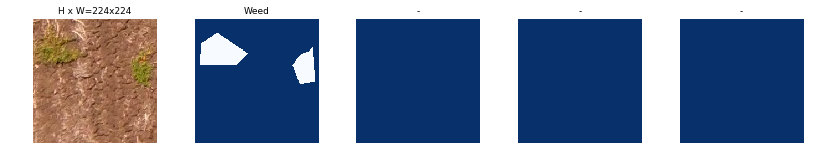

image_id 5


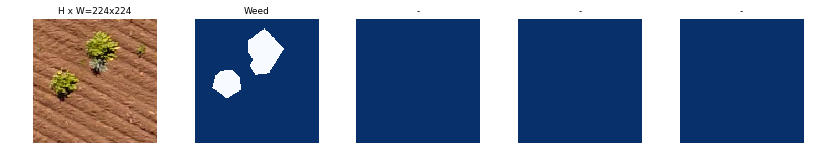

image_id 6


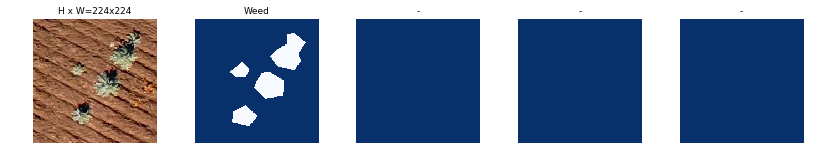

image_id 23


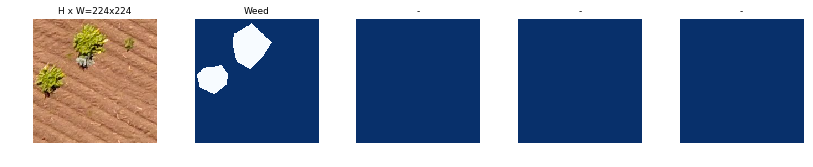

image_id 16


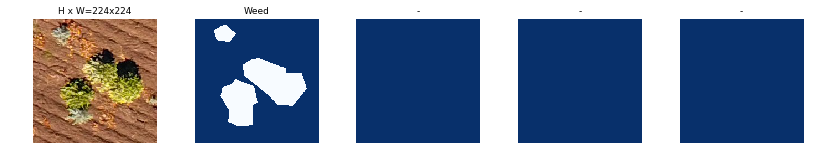

image_id 15


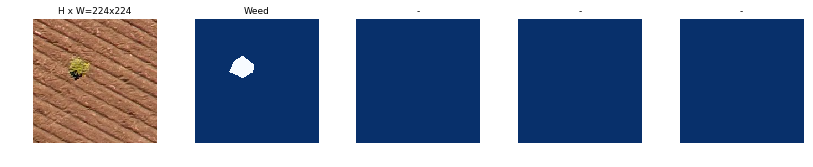

image_id 2


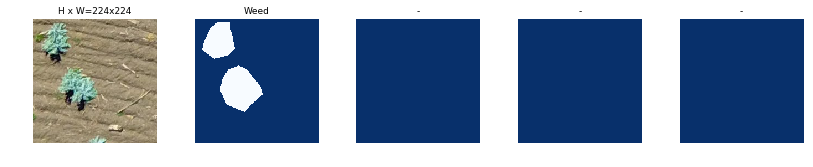

image_id 10


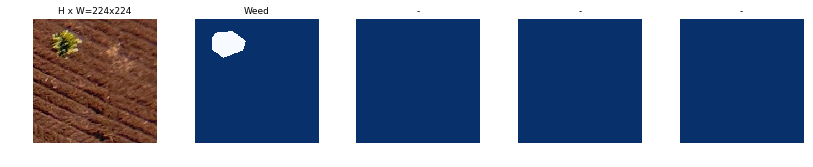

image_id 1


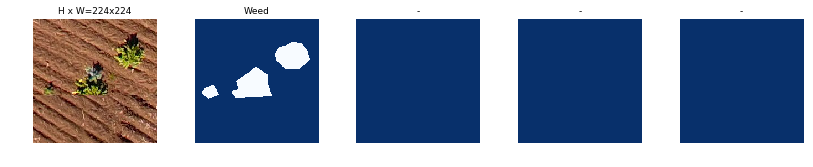

image_id 28


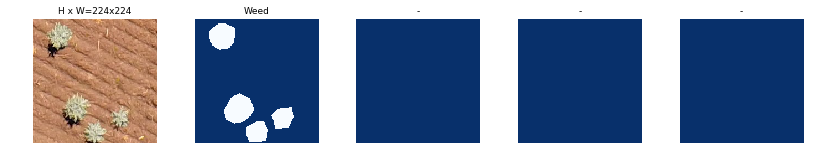

In [12]:
# Load and display random samples
image_ids = np.random.choice(dataset_test.image_ids, 10)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

In [13]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

weights_path = WEED_MODEL_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/jiaqihan1108/Mask_RCNN/logs/default_model.h5


image_id 2
image ID: shapes.2 (2) 
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -1.06274  max:    1.93749  float32


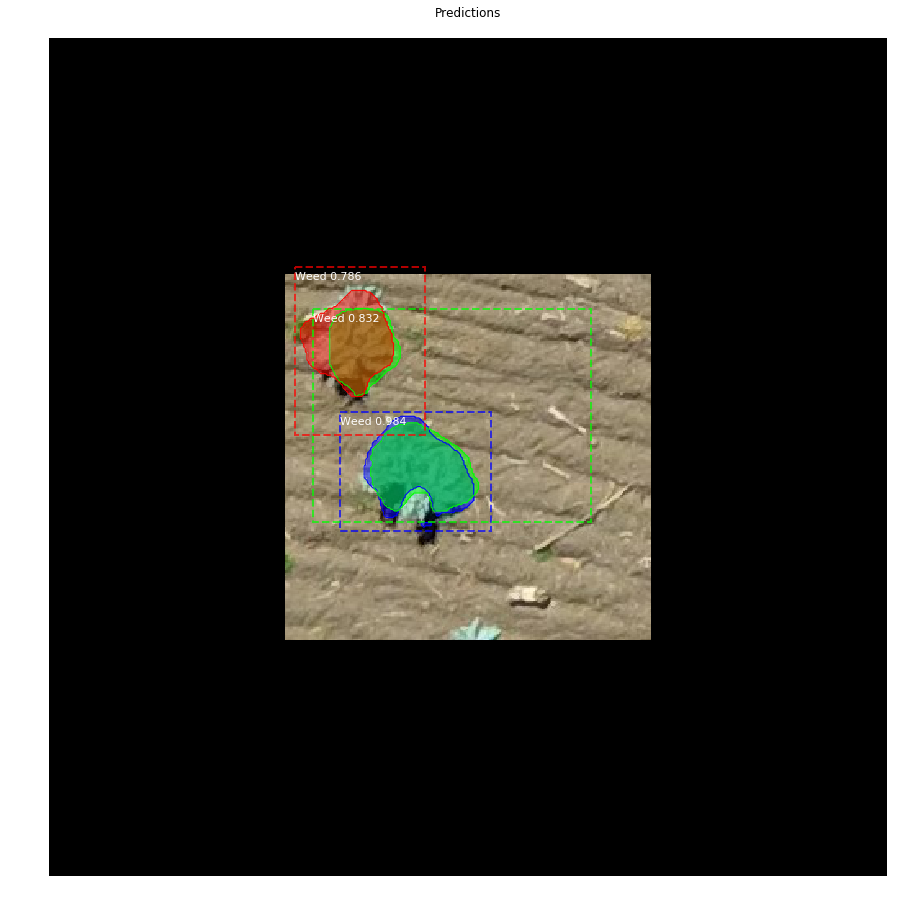

gt_class_id              shape: (1,)                  min:  157.00000  max:  157.00000  int32
gt_bbox                  shape: (1, 4)                min:  150.00000  max:  312.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


In [14]:

image_id = random.choice(dataset_test.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, config,
                           image_id, use_mini_mask=False)

info = dataset_test.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_test.image_reference(image_id)))
gt_class_id = gt_bbox[:, 1]

# Run object detection
results = model.detect([image], verbose=1)

# Display results
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'],
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

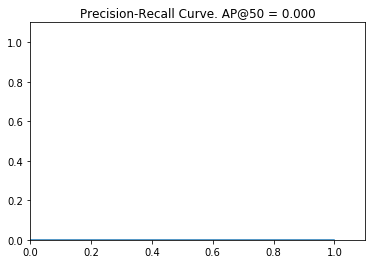

In [15]:

# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -3.43750  max:    3.22917  float64
positive_anchors         shape: (18, 4)               min:  152.00000  max:  312.00000  float64
negative_anchors         shape: (238, 4)              min: -175.52900  max:  687.52900  float64
neutral anchors          shape: (65216, 4)            min: -543.05801  max:  991.05801  float64
refined_anchors          shape: (18, 4)               min:  150.00000  max:  312.00000  float32


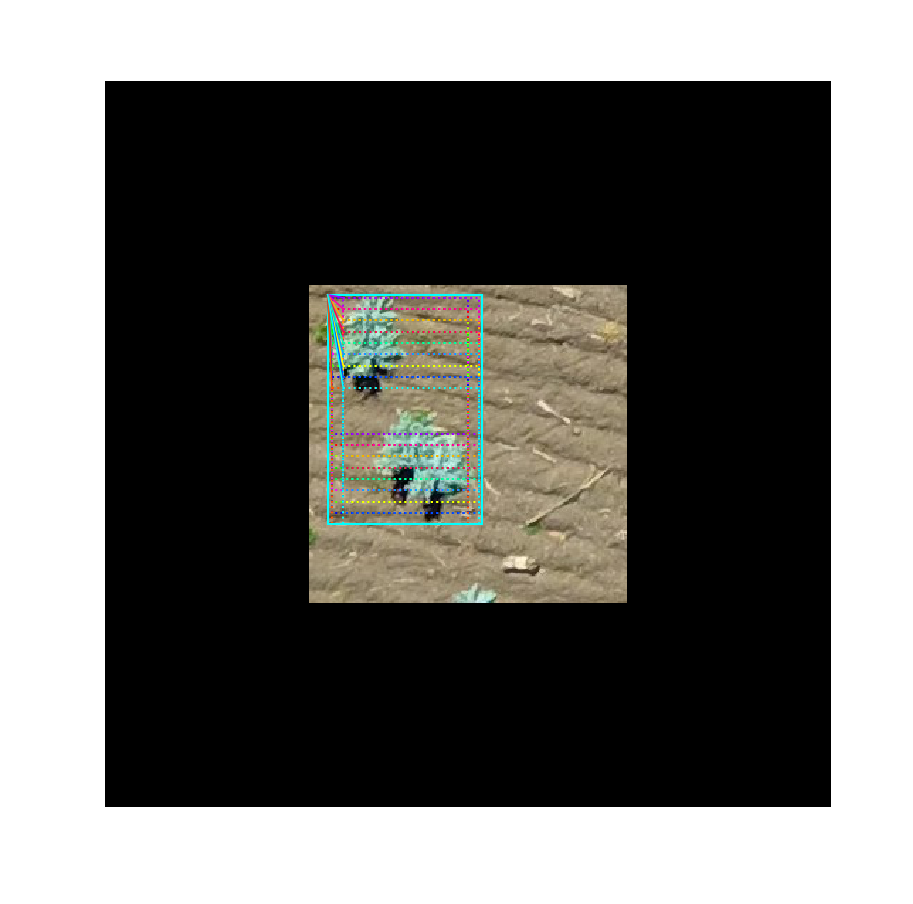

In [16]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors,gt_class_id, gt_bbox, config)

log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

In [17]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from
rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")),
    ("proposals", model.keras_model.get_layer("ROI").output),
])



rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -1.06274  max:    1.93749  float32
refined_anchors          shape: (1, 6000, 4)          min:  -18.06861  max:   19.13974  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (587,)                min:    0.00000  max: 5982.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


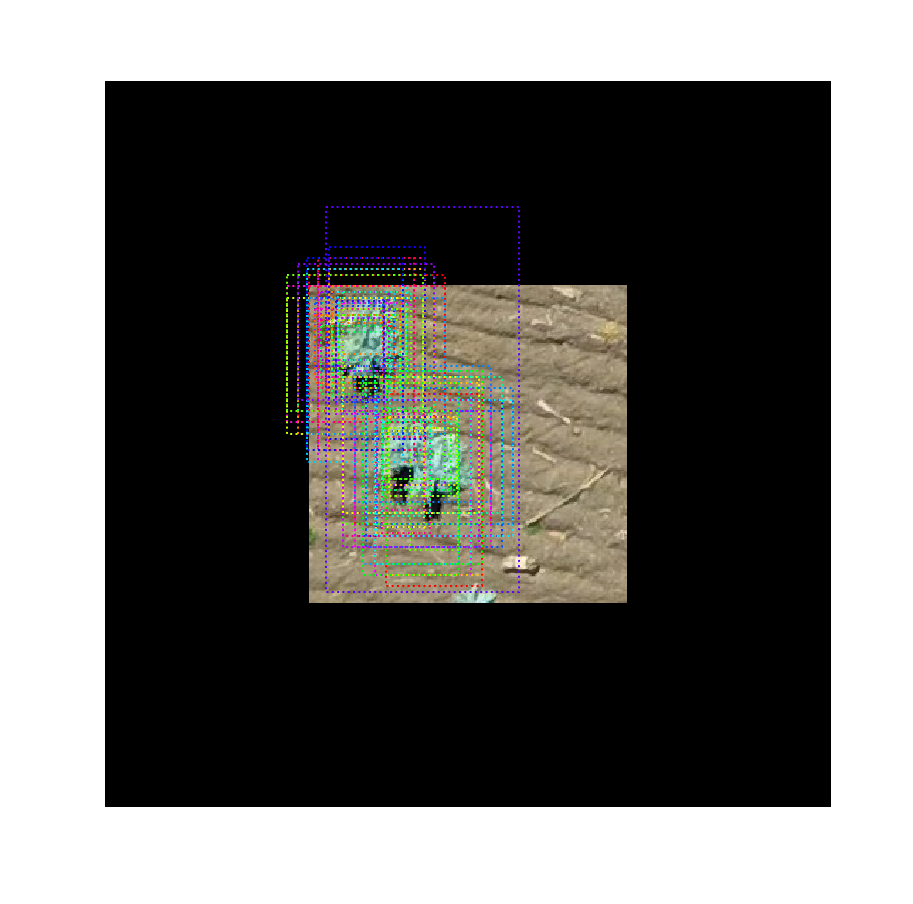

In [18]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

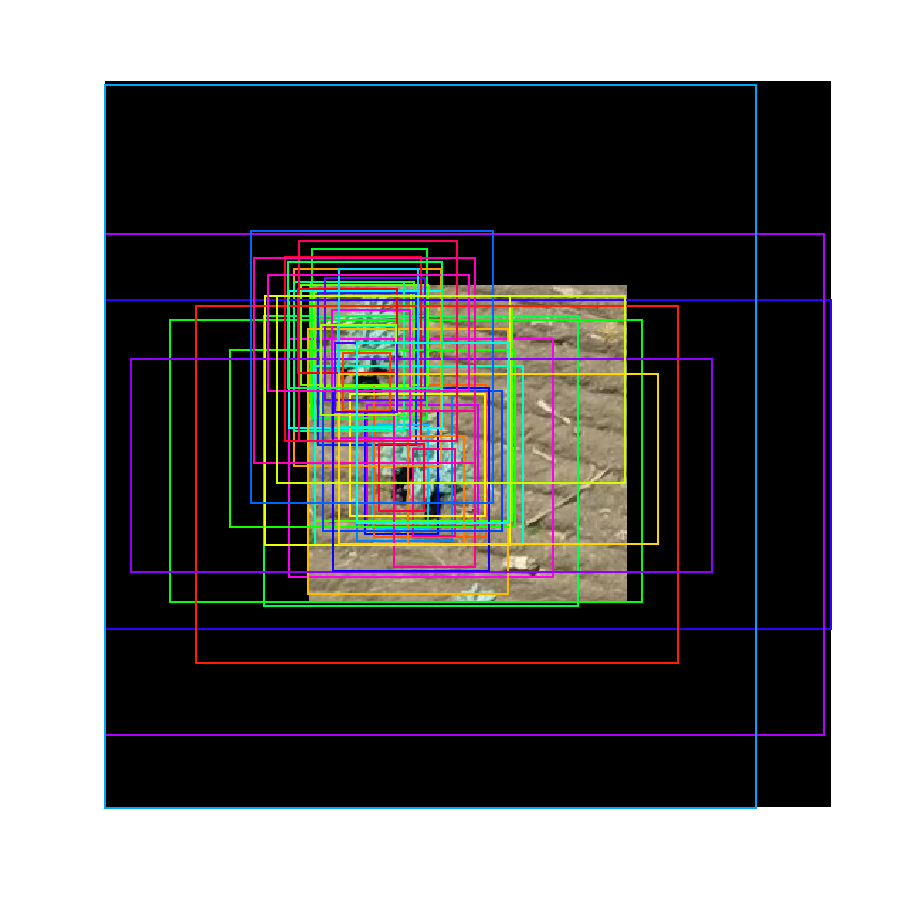

In [19]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [20]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))

All Anchors (65472)       Recall: 0.000  Positive anchors: 0
Refined Anchors ( 6000)   Recall: 0.000  Positive anchors: 0
Post NMS Anchors (   50)  Recall: 1.000  Positive anchors: 1


In [21]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -4.27673  max:    4.99818  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    0.99999  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


In [22]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]

3 detections: ['Weed' 'Weed' 'Weed']


In [23]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

587 Valid proposals out of 1000
25 Positive ROIs
[('BG', 975), ('Weed', 25)]


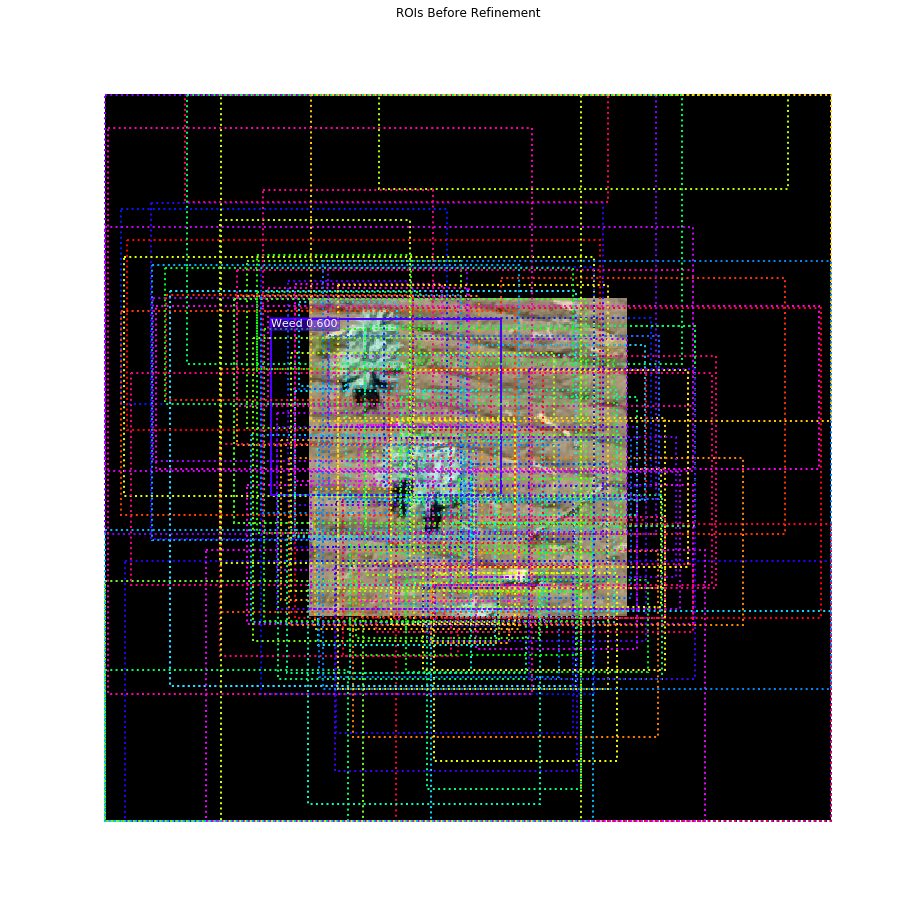

In [24]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())


roi_bbox_specific        shape: (1000, 4)             min:   -2.82621  max:    4.99818  float32
refined_proposals        shape: (1000, 4)             min:  -20.00000  max:  633.00000  int32


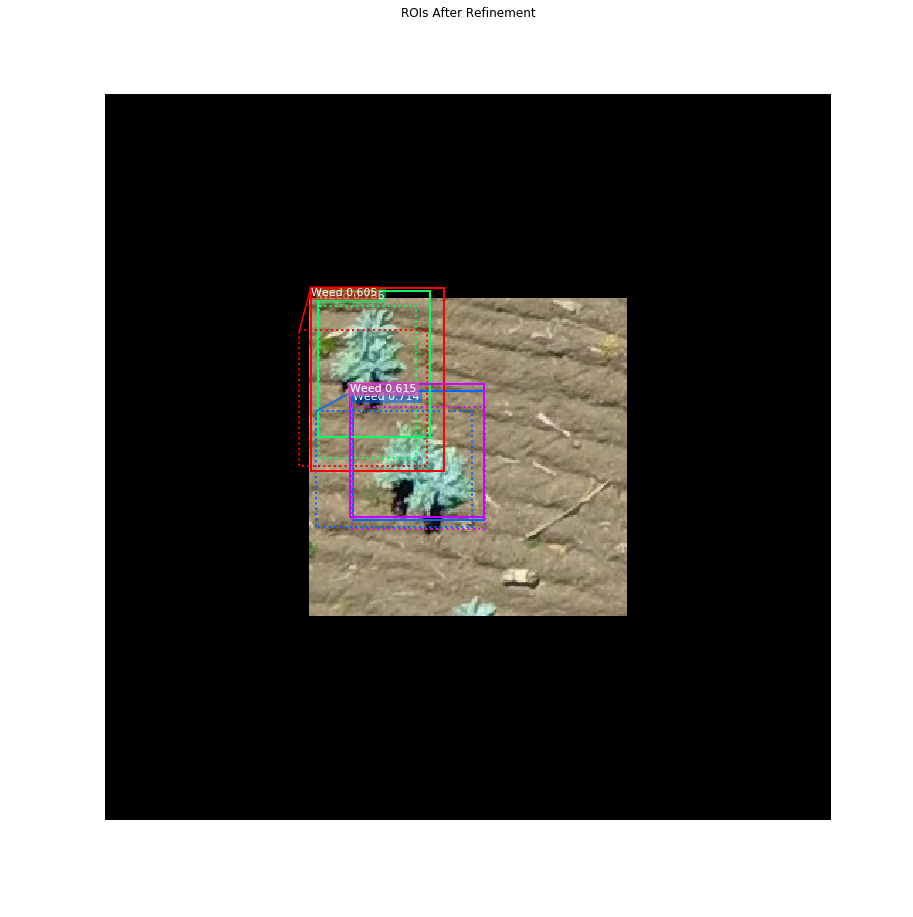

In [25]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

In [26]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 25 detections:
[  0   8  11  14  20  26  28  31  47  50  51  56  58  59  62  66  72  85
 108 109 112 164 170 185 315]


In [27]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 14:
[  0   8  11  14  26  31  50  51  59  66  85 109 112 185]


In [28]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

Weed                  : [  0   8  11  14  26  31  50  51  59  66  85 109 112 185] -> [109  66   8]

Kept after per-class NMS: 3
[  8  66 109]


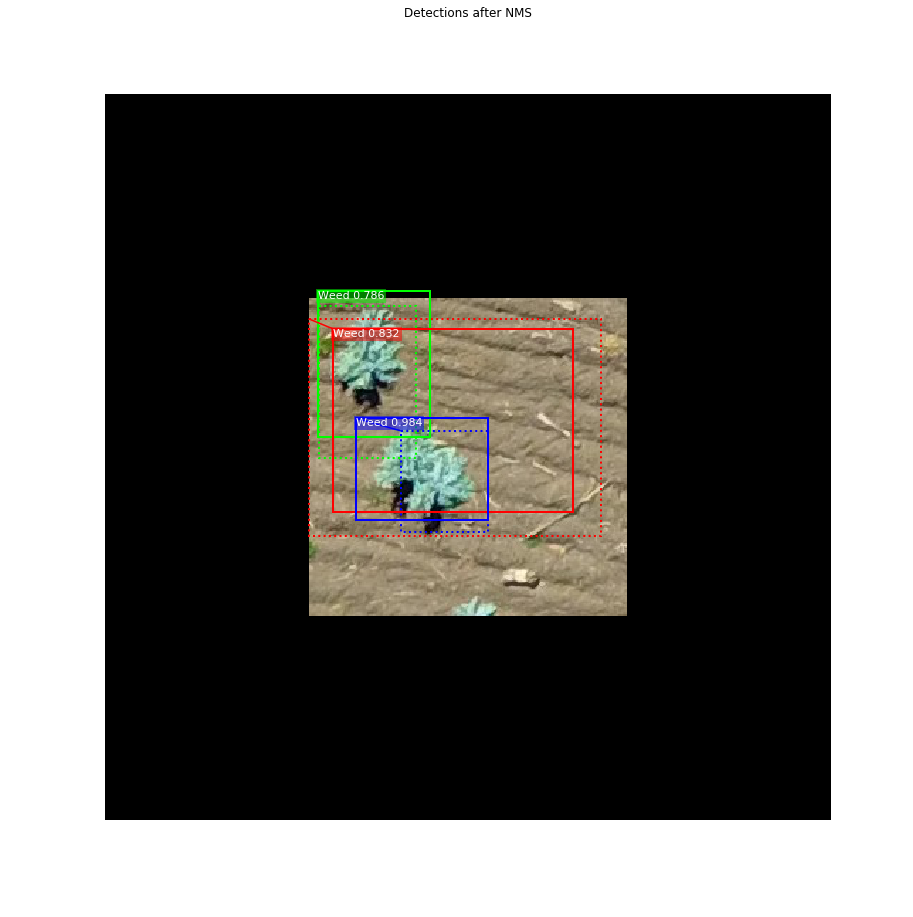

In [29]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

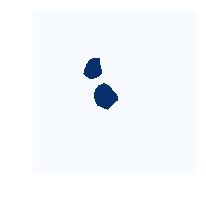

In [30]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

In [31]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    0.99999  float32
3 detections: ['Weed' 'Weed' 'Weed']
